In [1]:
import config
import robin_stocks as rb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
# import the username and password from the config.py file. If you choose to clone this
# repository and upload online, include the config.py file in gitignore to keep your
# personal information hidden
username = config.robinUser
password = config.robinPassword

# login to robinhood
rb.login(username, password)

chip_makers = ['AMD', 'INTC']

In [3]:
amd = pd.DataFrame(rb.stocks.get_stock_historicals('AMD', interval='day', span='5year'))
intel = pd.DataFrame(rb.stocks.get_stock_historicals('INTC', interval='day', span='5year'))
btc = pd.DataFrame(rb.crypto.get_crypto_historicals('BTC', interval='day', span='5year'))
eth = pd.DataFrame(rb.crypto.get_crypto_historicals('ETH', interval='day', span='5year'))
df_list = [amd, intel, btc, eth]

In [4]:
def shift_string(date):
    s = str(int(date[8:10]) - 1)
    if len(s) == 1: s = '0' + s
    return date[:8] + s + date[10:]

def shift_day_up_1(df):
    return df['begins_at'].apply(shift_string)

In [5]:
amd

,begins_at,open_price,close_price,high_price,low_price,volume,session,interpolated,symbol
0,2015-06-29T00:00:00Z,2.410000,2.340000,2.420000,2.310000,22971506,reg,False,AMD
1,2015-06-30T00:00:00Z,2.430000,2.400000,2.430000,2.350000,19381262,reg,False,AMD
2,2015-07-01T00:00:00Z,2.470000,2.420000,2.480000,2.360000,19374972,reg,False,AMD
3,2015-07-02T00:00:00Z,2.430000,2.530000,2.630000,2.390000,31185949,reg,False,AMD
4,2015-07-06T00:00:00Z,2.460000,2.470000,2.540000,2.440000,20349371,reg,False,AMD
...,...,...,...,...,...,...,...,...,...
1255,2020-06-22T00:00:00Z,54.670000,54.760000,55.170000,53.740000,44704781,reg,False,AMD
1256,2020-06-23T00:00:00Z,55.050000,53.990000,55.370000,53.870000,48089011,reg,False,AMD
1257,2020-06-24T00:00:00Z,53.940000,52.390000,54.740000,51.920000,53535548,reg,False,AMD
1258,2020-06-25T00:00:00Z,52.560000,51.930000,52.700000,50.540000,51129614,reg,False,AMD


In [6]:
amd['begins_at'] = shift_day_up_1(amd)
intel['begins_at'] = shift_day_up_1(intel)

In [7]:
def set_dataframe_index(df):
    df.set_index('begins_at', inplace=True)

In [8]:
def set_prices_to_floats(df):
    df['open_price'] = df['open_price'].astype(float)
    df['close_price'] = df['close_price'].astype(float)
    df['pct_change'] = (df['close_price'] - df['open_price'])/ df['open_price']

In [9]:
def drop_bad_columns(df):
    df.drop(["open_price",'close_price', 'high_price', 'low_price', 'volume', 'session', 'interpolated', 'symbol'], axis=1, inplace=True)

In [10]:
def prepare_data():
    for df in df_list:
        set_dataframe_index(df)
        set_prices_to_floats(df)
        drop_bad_columns(df)

In [11]:
prepare_data()

In [12]:
sufs = ['_amd', '_intel', '_btc','_eth']

In [13]:
merger_stocks = pd.merge(amd, intel, on='begins_at', how='outer', suffixes=('_a','_b'))
merger_crypto = pd.merge(btc, eth, on='begins_at', how='outer', suffixes=('_a','_b'))

def avg_pct_change(df):
    df['avg_change'] = (df['pct_change_a'] + df['pct_change_b'])/2
    df.drop(['pct_change_a', 'pct_change_b'], axis=1, inplace=True)
    

avg_pct_change(merger_stocks)
avg_pct_change(merger_crypto)

total_merge = pd.merge(merger_crypto, merger_stocks, on='begins_at', how='outer', suffixes=('_a','_b'))

In [14]:
total_merge.dropna(inplace=True)

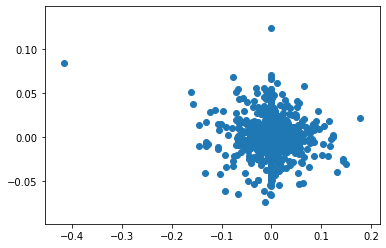

In [15]:
plt.scatter(total_merge['avg_change_a'],total_merge['avg_change_b'])

,avg_change_a,avg_change_b,bool_baby,went_up
begins_at,,,,
2015-06-29T00:00:00Z,0.000000,-0.009682,False,0
2015-07-01T00:00:00Z,0.000000,0.026789,True,1
2015-07-05T00:00:00Z,0.000000,-0.001274,False,0
2015-07-06T00:00:00Z,0.000000,0.012757,True,1
2015-07-07T00:00:00Z,0.000000,-0.012792,False,0
...,...,...,...,...
2020-06-21T00:00:00Z,-0.005043,0.003837,True,1
2020-06-22T00:00:00Z,0.057753,-0.011871,False,0
2020-06-23T00:00:00Z,-0.002249,-0.018979,False,0


In [49]:
total_merge

,avg_change_a,avg_change_b,bool_baby
begins_at,,,
2015-06-29T00:00:00Z,0.000000,-0.009682,False
2015-07-01T00:00:00Z,0.000000,0.026789,True
2015-07-05T00:00:00Z,0.000000,-0.001274,False
2015-07-06T00:00:00Z,0.000000,0.012757,True
2015-07-07T00:00:00Z,0.000000,-0.012792,False
...,...,...,...
2020-06-21T00:00:00Z,-0.005043,0.003837,True
2020-06-22T00:00:00Z,0.057753,-0.011871,False
2020-06-23T00:00:00Z,-0.002249,-0.018979,False


In [48]:
total_merge['bool_baby'] = total_merge['avg_change_b'] >= 0

# Logistic Regression

In [40]:
logmodel = LogisticRegression()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(total_merge['avg_change_a']), total_merge['bool_baby'], test_size=0.33)

In [46]:
logmodel.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
preds = logmodel.predict(x_test)

In [54]:
np.array(y_test)

array([ True,  True,  True, False, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True, False, False,  True,  True, False, False, False,  True,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True, False, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True, False, False, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [56]:
logmodel.predict(x_train)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [517]:
lm.fit(np.array(x_train).reshape(1,-1), np.array(y_train).reshape(1,-1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [520]:
preds = lm.predict(np.array(x_test).reshape(1,-1))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 818 is different from 403)

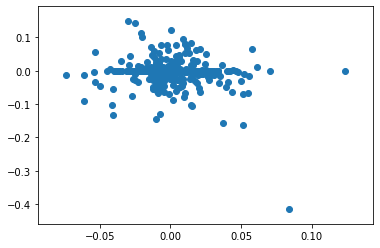

In [357]:
plt.scatter(y_test, preds)

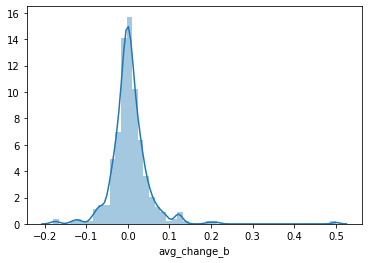

In [358]:
sns.distplot(y_test - preds[0])

In [359]:
np.sqrt(sklearn.metrics.mean_squared_error(y_test, preds[0]))

0.04842607183983118

In [360]:
blah = y_test - preds[0]
y_test

begins_at
2018-11-20T00:00:00Z   -0.041589
2019-04-14T00:00:00Z   -0.010047
2019-10-01T00:00:00Z   -0.012477
2018-12-25T00:00:00Z    0.054786
2020-03-25T00:00:00Z    0.055508
                          ...   
2018-02-25T00:00:00Z    0.020445
2018-07-15T00:00:00Z    0.002385
2020-03-11T00:00:00Z   -0.061121
2018-12-13T00:00:00Z    0.008276
2015-10-29T00:00:00Z   -0.008192
Name: avg_change_b, Length: 403, dtype: float64

In [361]:
test = pd.DataFrame([np.array(y_test).reshape(1,-1)[0], preds[0]])
test = test.transpose()

In [362]:
test.size

806

In [363]:
test[(test[0] > 0) & (test[1] > 0)].size

90

In [370]:
test[test[1] > 0].size

178

In [371]:
test[test[1] < 0].size

228

In [372]:
test[(test[0] < 0) & (test[1] < 0)].size

110

In [425]:
test[(test[1] > 0)].size

178

In [424]:
test[(test[0] > -0.005) & (test[1] > 0)].size

104

In [404]:
test[(test[0] < 0.01) & (test[1] < -0.02) & (test[1] > -0.04)].size

34

In [481]:
trial = test[(test[1] > -0.07) & (test[1] < 0.021)]
trial.reset_index(inplace=True)
trial

,index,0,1
0,2,-0.012477,-0.013355
1,3,0.054786,-0.067085
2,4,0.055508,-0.014643
3,6,0.020363,-0.001569
4,7,0.003048,0.006109
...,...,...,...
336,397,-0.006761,0.000000
337,398,0.020445,-0.000624
338,400,-0.061121,-0.013960
339,401,0.008276,-0.046613


In [482]:
cash = 100
for i in range(len(trial)):
    pct = trial[0][i] + 1
    cash = cash - 100 + 100*pct
cash

140.18389171627013

In [521]:
total_merge

,avg_change_a,avg_change_b,bool_baby,went_up
begins_at,,,,
2015-06-28T00:00:00Z,0.000000,-0.019572,False,0
2015-06-29T00:00:00Z,0.000000,-0.009682,False,0
2015-07-01T00:00:00Z,0.000000,0.026789,True,1
2015-07-05T00:00:00Z,0.000000,-0.001274,False,0
2015-07-06T00:00:00Z,0.000000,0.012757,True,1
...,...,...,...,...
2020-06-21T00:00:00Z,-0.005043,0.003837,True,1
2020-06-22T00:00:00Z,0.057753,-0.011871,False,0
2020-06-23T00:00:00Z,-0.002249,-0.018979,False,0


In [553]:
total_merge.drop('bool_baby', axis=1, inplace=True)


KeyError: "['bool_baby'] not found in axis"

In [554]:
total_merge = total_merge[total_merge['avg_change_a'] != 0]

# Linear Regression

In [17]:
x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(total_merge['avg_change_a']), total_merge['avg_change_b'], test_size=0.33)

In [18]:
lmo = LinearRegression()

In [19]:
x_train.size == y_train.size

True

In [20]:
lmo.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
predictions = lmo.predict(x_test)

In [22]:
trial = pd.DataFrame([predictions, y_test])

In [23]:
trial = trial.transpose()

In [24]:
trial

,0,1
0,0.001284,0.021310
1,0.001059,-0.000424
2,0.001284,-0.001901
3,0.000965,0.005145
4,0.001284,-0.019444
...,...,...
398,0.001284,0.000945
399,0.001284,-0.002690
400,0.001284,-0.016143
401,0.001284,0.006721


In [25]:
trial

,0,1
0,0.001284,0.021310
1,0.001059,-0.000424
2,0.001284,-0.001901
3,0.000965,0.005145
4,0.001284,-0.019444
...,...,...
398,0.001284,0.000945
399,0.001284,-0.002690
400,0.001284,-0.016143
401,0.001284,0.006721


In [26]:
trial[(trial[0] > 0)].size

696

In [27]:
trial[(trial[0] > 0) & trial[1] > 0].size

694

In [31]:
trial[(trial[0] > 0) & (trial[1] > 0)].size

370

In [29]:
up = trial[(trial[0] > 0.001) & (trial[0] < 0.002)]
up.reset_index(inplace=True)

In [680]:
profit = 0.0
for i in range(len(up)):
    pct = up[1][i] * 100
    profit += pct
    
profit

5.853293161047666

In [673]:
up.reset_index(inplace=True)

In [679]:
up.size

96

In [652]:
up

,0,1
0,-0.004286,-0.021639
3,-0.002451,0.004323
8,-0.000901,-0.008955
10,-0.004465,0.018066
11,-0.001540,-0.013973
...,...,...
181,-0.000751,-0.001205
185,-0.007901,-0.030196
189,-0.000639,-0.007835
190,-0.000553,-0.035695
